In [1]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

In [2]:
class OrderParameter:

    def __init__(self, i, j, traj):
        self.i = i
        self.j = j
        self.traj = traj
        
    def __str__(self):
        return str(self.i)

In [3]:
class SimilarityMatrix:

    def __init__(self, max_OPs):
        self.max_OPs = max_OPs
        self.matrix = [[] for i in range(max_OPs)]
        self.OPs = []

    def add_OP(self, OP):
        if len(self.OPs) == self.max_OPs:
            mut_info = []
            existing = []
            for i in range(len(self.OPs)):
                mut_info.append(mutual_info(self.OPs[i].traj, OP.traj))
                product = 1
                for j in range(len(self.OPs)):
                    if not i == j:
                        product = product * self.matrix[i][j]
                existing.append(product)
            update = False
            difference = None
            for i in range(len(self.OPs)):
                candidate_info = 1
                for j in range(len(self.OPs)):
                    if not i == j:
                        candidate_info = candidate_info * mut_info[j]
                if candidate_info > existing[i]:
                    update = True
                    if difference == None:
                        difference = candidate_info - existing[i]
                        old_OP = i
                    else:
                        if (candidate_info - existing[i]) > difference:
                            difference = candidate_info - existing[i]
                            old_OP = i
            if update == True:
                mut_info[old_OP] = mutual_info(OP.traj, OP.traj)
                self.matrix[old_OP] = mut_info
                self.OPs[old_OP] = OP
                for i in range(len(self.OPs)):
                    self.matrix[i][old_OP] = mut_info[i]
        else:
            for i in range(len(self.OPs)):
                mut_info = mutual_info(OP.traj, self.OPs[i].traj)
                self.matrix[i].append(mut_info)
                self.matrix[len(self.OPs)].append(mut_info)
            self.matrix[len(self.OPs)].append(mutual_info(OP.traj, OP.traj))
            self.OPs.append(OP)
        
    def reduce(self):
        min_val = 10
        index = -1
        for i in range(len(self.matrix)):
            product = 1
            for j in range(len(self.matrix[i])):
                if not i == j:
                    product = product * self.matrix[i][j]
            if product < min_val:
                index = i
                min_val = product
        self.matrix.pop(index)
        for i in range(len(self.matrix)):
            self.matrix[i].pop(index)
        self.OPs.pop(index)
        
    def min_product(self):
        min_val = 10
        for i in range(len(self.matrix)):
            product = 1
            for j in range(len(self.matrix[i])):
                if not i == j:
                    product = product * self.matrix[i][j]
            if product < min_val:
                min_val = product
        return min_val
    
    def get_OPs(self):
        return self.OPs
    
    def __str__(self):
        output = ""
        output = output + "OPs:\n"
        for i in self.OPs:
            output = output + str(i) + "\n"
        output = output + "\nMatrix:\n"
        for i in self.matrix:
            for j in i:
                output = output + str(j) + " "
            output = output + "\n"
        return output
                

In [4]:
# Finds the number of local maxima in a noisy probability distribution
def find_wells(prob):

    energy = []
    for i in (range(len(prob))):
        if prob[i] == 0:
            energy.append(np.inf)
        else:
            energy.append(-1 * np.log(prob[i]))

    wells = 0
    max = np.inf
    min = np.inf
    d = 1
    i = 0
    for x in energy:
        if x > max:
            max = x
            if (max - min > 1):
                min = x
                d = 1
        elif x < min:
            min = x
            if (max - min > 1):
                if d == 1:
                    wells = wells + 1
                max = x
                d = -1
        i = i + 1

    return wells

In [5]:
# Binning values of one order parameter to create a 1 dimensional probability space
def d1_bin(x, bins = 80):

    min_val = np.amin(x)
    max_val = np.amax(x)
    span = max_val - min_val

    p_x = [0.0 for i in range(bins)]

    for i in x:
        bin_num = (int) (bins * (i - min_val) / span)
        if bin_num == bins:
            bin_num -= 1
        p_x[bin_num] += 1.0 / len(x)

    return p_x

In [6]:
# Binning valus of two order parameters to create a 2 dimensional probability space
def d2_bin(x, y, bins = 80):

    if len(x) != len(y):
        raise Exception("Order parameter lists are of different size.")

    min_x = np.amin(x)
    max_x = np.amax(x)
    span_x = max_x - min_x

    min_y = np.amin(y)
    max_y = np.amax(y)
    span_y = max_y - min_y

    p_xy = [[0.0 for i in range(bins)] for j in range(bins)]

    for i in range(len(x)):
        bin_x = (int) (bins * (x[i] - min_x) / span_x)
        bin_y = (int) (bins * (y[i] - min_y) / span_y)
        if bin_x == bins:
            bin_x -= 1
        if bin_y == bins:
            bin_y -= 1
        p_xy[bin_x][bin_y] += 1.0 / len(x)

    return p_xy

In [7]:
# Calculates normalized mutual information of two order parameters
def mutual_info(x, y, bins = 80):

    p_x = d1_bin(x, bins)
    p_y = d1_bin(y, bins)
    p_xy = d2_bin(x, y, bins)

    info = 0
    entropy = 0

    for i in range(len(p_x)):
        for j in range(len(p_y)):
            if p_xy[i][j] != 0:
                entropy -= p_xy[i][j] * np.log(p_xy[i][j])
                info += p_xy[i][j] * np.log(p_xy[i][j] / (p_x[i] * p_y[j]))

    if ((1 - (info / entropy)) < 0):
        return 0.0
    else:
        return (1 - (info / entropy))

In [8]:
# Generating random numbers
x = []
x2 = []
x4 = []
x5 = []
xm1 = []
xm4 = []
y = []
y2 = []
y4 = []
y5 = []
ym1 = []
ym4 = []
z = []
w = []
a = []
a2 = []
a3 = []
am1 = []
am2 = []
am3 = []
b = []
b2 = []
b3 = []
bm1 = []
bm2 = []
bm3 = []
c = []
d = []
e = []
f = []
xv1 = []
xv2 = []
xv3 = []
xv4 = []
xv5 = []
yv1 = []
yv2 = []
yv3 = []
yv4 = []
yv5 = []
zv1 = []
zv2 = []
zv3 = []
av1 = []
av2 = []
av3 = []
bv1 = []
bv2 = []
bv3 = []
for i in range(50000):
    tmp1 = random.random()
    tmp1 = 1 - (tmp1 * tmp1 * tmp1 * tmp1)
    if random.random() < 0.5:
        tmp1 = -1 * tmp1
    tmp2 = random.random()
    tmp2 = (tmp2 * tmp2 * tmp2 * tmp2)/2
    if random.random() < 0.5:
        tmp2 = 1 - tmp2
    if random.random() < 0.5:
        tmp2 = -1 * tmp2
    tmp3 = random.random()
    tmp3 = 1 - (tmp3 * tmp3 * tmp3 * tmp3)
    if random.random() < 0.5:
        tmp3 = -1 * tmp3
    tmp4 = random.random()
    tmp4 = 1 - (tmp4 * tmp4 * tmp4 * tmp4)
    if random.random() < 0.5:
        tmp4 = -1 * tmp4
    tmp5 = random.random()
    tmp5 = 1 - (tmp5 * tmp5 * tmp5)
    if random.random() < 0.5:
        tmp5 = -1 * tmp5
    x.append(tmp1)
    x2.append(tmp1 * 2)
    x4.append(tmp1 * 4)
    x5.append(tmp1 * 5)
    xm1.append(tmp1 * (-1))
    xm4.append(tmp1 * (-4))
    xv1.append(tmp1 + (random.random() / 10))
    xv2.append(tmp1 + (random.random() / 10))
    xv3.append(tmp1 + (random.random() / 10))
    xv4.append(tmp1 + (random.random() / 10))
    xv5.append(tmp1 + (random.random() / 10))
    y.append(tmp2)
    y2.append(tmp2 * 2)
    y4.append(tmp2 * 4)
    y5.append(tmp2 * 5)
    ym1.append(tmp2 * (-1))
    ym4.append(tmp2 * (-4))
    yv1.append(tmp2 + (random.random() / 10))
    yv2.append(tmp2 + (random.random() / 10))
    yv3.append(tmp2 + (random.random() / 10))
    yv4.append(tmp2 + (random.random() / 10))
    yv5.append(tmp2 + (random.random() / 10))
    z.append(tmp3)
    zv1.append(tmp3 + (random.random() / 10))
    zv2.append(tmp3 + (random.random() / 10))
    zv3.append(tmp3 + (random.random() / 10))
    w.append(5 * tmp1 + tmp2)
    a.append(tmp4)
    a2.append(tmp4 * 2)
    a3.append(tmp4 * 3)
    am1.append(tmp4 * (-1))
    am2.append(tmp4 * (-2))
    am3.append(tmp4 * (-3))
    av1.append(tmp4 + (random.random() / 10))
    av2.append(tmp4 + (random.random() / 10))
    av3.append(tmp4 + (random.random() / 10))
    b.append(tmp5)
    b2.append(tmp5 * 2)
    b3.append(tmp5 * 3)
    bm1.append(tmp5 * (-1))
    bm2.append(tmp5 * (-2))
    bm3.append(tmp5 * (-3))
    bv1.append(tmp5 + (random.random() / 10))
    bv2.append(tmp5 + (random.random() / 10))
    bv3.append(tmp5 + (random.random() / 10)) 
    c.append(4 * tmp2 + tmp5)
    d.append(tmp3 + 5 * tmp4)
    e.append(tmp3 + tmp4 + 4 * tmp5)
    f.append(10 * tmp1 + tmp2 + tmp3 + tmp4 + tmp5)

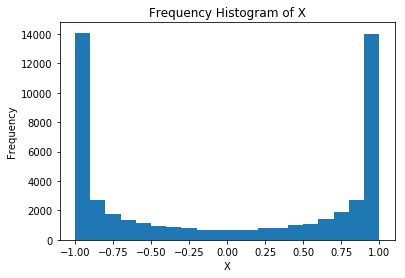

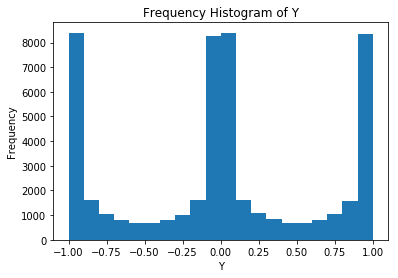

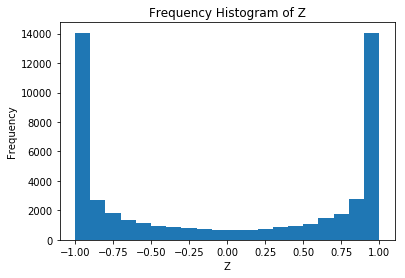

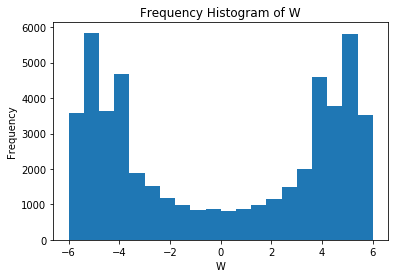

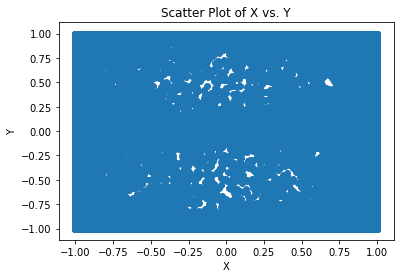

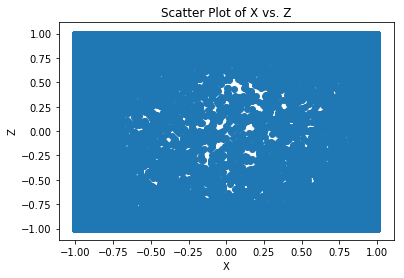

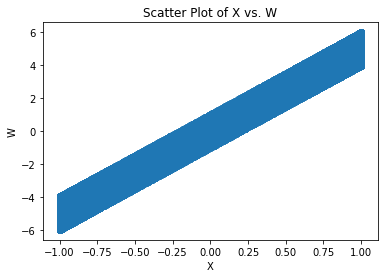

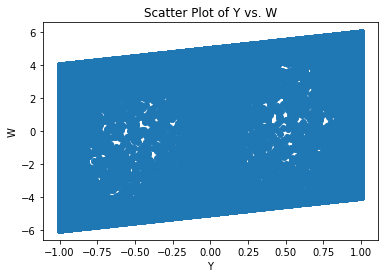

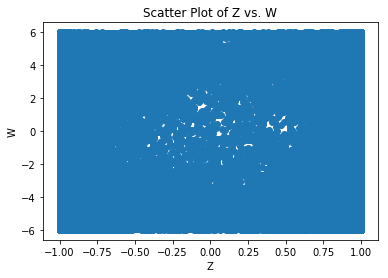

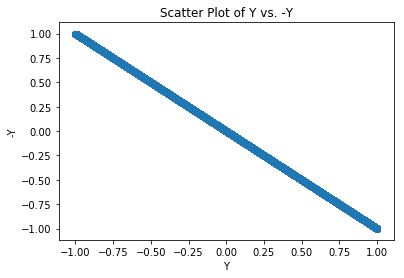

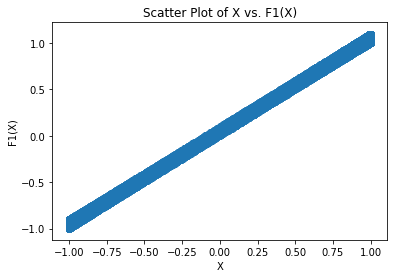

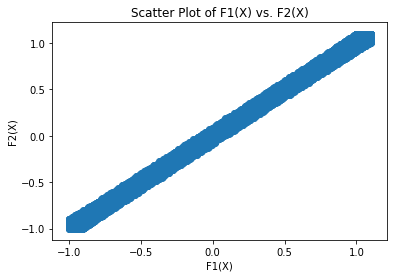

In [10]:
# Graphing stuff to make sure it's right
plt.hist(x, bins=20)
plt.title("Frequency Histogram of X")
plt.xlabel("X")
plt.ylabel("Frequency")
plt.show()
plt.hist(y, bins=20)
plt.title("Frequency Histogram of Y")
plt.xlabel("Y")
plt.ylabel("Frequency")
plt.show()
plt.hist(z, bins=20)
plt.title("Frequency Histogram of Z")
plt.xlabel("Z")
plt.ylabel("Frequency")
plt.show()
plt.hist(w, bins=20)
plt.title("Frequency Histogram of W")
plt.xlabel("W")
plt.ylabel("Frequency")
plt.show()
plt.scatter(x, y)
plt.title("Scatter Plot of X vs. Y")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
plt.scatter(x, z)
plt.title("Scatter Plot of X vs. Z")
plt.xlabel("X")
plt.ylabel("Z")
plt.show()
plt.scatter(x, w)
plt.title("Scatter Plot of X vs. W")
plt.xlabel("X")
plt.ylabel("W")
plt.show()
plt.scatter(y, w)
plt.title("Scatter Plot of Y vs. W")
plt.xlabel("Y")
plt.ylabel("W")
plt.show()
plt.scatter(z, w)
plt.title("Scatter Plot of Z vs. W")
plt.xlabel("Z")
plt.ylabel("W")
plt.show()
plt.scatter(y, ym1)
plt.title("Scatter Plot of Y vs. -Y")
plt.xlabel("Y")
plt.ylabel("-Y")
plt.show()
plt.scatter(x, xv1)
plt.title("Scatter Plot of X vs. F1(X)")
plt.xlabel("X")
plt.ylabel("F1(X)")
plt.show()
plt.scatter(xv1, xv2)
plt.title("Scatter Plot of F1(X) vs. F2(X)")
plt.xlabel("F1(X)")
plt.ylabel("F2(X)")
plt.show()

In [11]:
# Finding number of wells and mutual info
print("X has " + str(find_wells(d1_bin(x, bins=20))) + " wells")
print("Y has " + str(find_wells(d1_bin(y, bins=20))) + " wells")
print("W has " + str(find_wells(d1_bin(w, bins=20))) + " wells")
print("C has " + str(find_wells(d1_bin(c, bins=20))) + " wells")
print("D has " + str(find_wells(d1_bin(d, bins=20))) + " wells")
print("E has " + str(find_wells(d1_bin(e, bins=20))) + " wells")
print("F has " + str(find_wells(d1_bin(f, bins=20))) + " wells")
print("X and Y: " + str(mutual_info(x, y)))
print("X and W: " + str(mutual_info(x, w)))
print("Y and W: " + str(mutual_info(y, w)))
print("X and 4X: " + str(mutual_info(x, x4)))
print("X and -4X: " + str(mutual_info(x, xm4)))
print("X and X: " + str(mutual_info(y, y2)))

X has 2 wells
Y has 3 wells
W has 2 wells
C has 1 wells
D has 2 wells
E has 2 wells
F has 2 wells
X and Y: 0.9899823144008841
X and W: 0.6880744167561861
Y and W: 0.8921664206024246
X and 4X: 0.0
X and -4X: 0.0
X and X: 0.0


In [12]:
# Grouping
def grouping(nw, al):
    groups = [[] for i in range(len(nw))]
    for OP in al:
        max_val = 100
        group = -1
        for i in range(len(nw)):
            tmp = mutual_info(OP.traj, nw[i].traj)
            if tmp < max_val:
                max_val = tmp
                group = i
        groups[group].append(OP)
    return groups

In [13]:
# Group evaulation
def group_evaluation(al):
    mut_info = []
    for i in range(len(al)):
        product = 1
        for j in range(len(al)):
            if not i == j:
                product = product * (mutual_info(al[i].traj, al[j].traj))
        mut_info.append(product)
    max_val = 10
    op = -1
    for i in range(len(al)):
        if mut_info[i] < max_val:
            op = i
            max_val = mut_info[i]
    return al[op]

In [14]:
def find_ops(old_ops, max_outputs):
    
    matrix = SimilarityMatrix(max_outputs)
    
    for i in old_ops:
        matrix.add_OP(i)
        
    for i in old_ops[::-1]:
        matrix.add_OP(i)
    
    tmp = copy.deepcopy(matrix)
    means = []
    products = []
    
    for i in range(max_outputs - 1):
        means.append(tmp.min_product() ** (1.0/(len(tmp.OPs) - 1)))
        products.append(tmp.min_product())
        tmp.reduce()
        
    return (means, products, matrix)
        
    num_ops = -1
    max_jump = 0
    
    for i in range(len(means) - 1):
        diff = means[i + 1] - means[i]
        if diff > max_jump and means[i] > 0.5:
            max_jump = diff
            num_ops = i + 1
            
    for i in range(num_ops):
        matrix.reduce()
        
    groups = grouping(matrix.OPs, old_ops)
    final_ops = []
    
    for i in groups:
        final_ops.append(group_evaluation(i))

    return final_ops


In [34]:
tmp = [zv1, x, a2, w, av1, y5, am1, xv1, d, x2, bv1, yv1, zv3, y2, av3, bm2, bv2, ym1, xv3, b2, yv3, zv2, a, am3, b3, xm1, f, xv2, e, av2, bv3, yv2, b, yv4, am2, x4, c, yv5, y4, bm3, xv4, x5, a3, bm1, z, y, xv5, xm4, ym4]
#       0   1  2   3   4    5   6    7   8  9    10   11   12  13   14   15  16    17  18   19  20    21  22 23   24  25   26 27   28  29  30    31  32 33   34   35  36 37   38  39   40   41  42  43   44 45 46   47   48
string_array = ["zv1", "x", "a2", "w", "av1", "y5", "am1", "xv1", "d", "x2", "bv1", "yv1", "zv3", "y2", "av3", "bm2", "bv2", "ym1", "xv3", "b2", "yv3", "zv2", "a", "am3", "b3", "xm1", "f", "xv2", "e", "av2", "bv3", "yv2", "b", "yv4", "am2", "x4", "c", "yv5", "y4", "bm3", "xv4", "x5", "a3", "bm1", "z", "y", "xv5", "xm4", "ym4"]
ops = [OrderParameter(i, i, tmp[i]) for i in range(len(tmp))]
final_ops = find_ops(ops, 30)


28
28


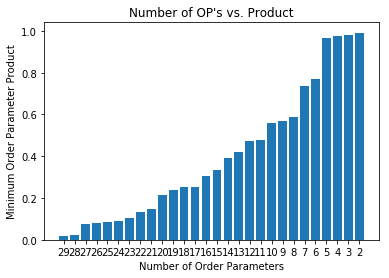

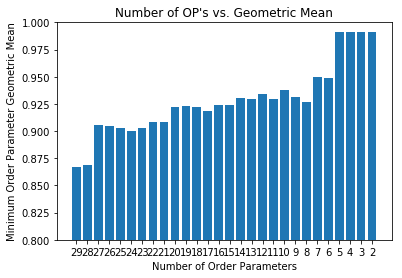

In [36]:
nums = []
means = copy.deepcopy(final_ops[0])
means.pop(0)
products = copy.deepcopy(final_ops[1])
products.pop(0)
for i in range(28):
    nums.append(str(29 - i))
print(len(products))
print(len(nums))
plt.bar(nums, products)
plt.title("Number of OP\'s vs. Product")
plt.xlabel("Number of Order Parameters")
plt.ylabel("Minimum Order Parameter Product")
plt.show()

plt.bar(nums, means)
plt.title("Number of OP\'s vs. Geometric Mean")
plt.xlabel("Number of Order Parameters")
plt.ylabel("Minimum Order Parameter Geometric Mean")
plt.ylim(0.8, 1.0)
plt.show()